In [1]:
!pip install rdkit-pypi -qqq
!pip install smilite

In [10]:
import pandas as pd
import numpy as np
import smilite
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

tf.random.set_seed(42)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

#loading files
df = pd.read_csv('/content/drive/My Drive/ML2_final/zinc_data.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# df=df.iloc[:50000,:]
smiles = df['smiles'].tolist()
for i in range(len(smiles)):
  smiles[i] = smilite.simplify_smile(smiles[i])


print(df.shape)
# print(smiles)
df['simple_smiles']=smiles

(427493, 2)


In [13]:
df.head()

,zinc_id,smiles,simple_smiles
0,ZINC000000008151,C[C@H]1[C@@H](O)[C@H](CO)O[C@@H](O)[C@@H]1N,CC1C(O)C(CO)OC(O)C1N
1,ZINC000000008153,CC[C@@H]1[C@@H](N)[C@@H](O)O[C@@H](CO)[C@@H]1O,CCC1C(N)C(O)OC(CO)C1O
2,ZINC000000008155,CC1(C)[C@@H](N)[C@@H](O)O[C@@H](CO)[C@@H]1O,CC1(C)C(N)C(O)OC(CO)C1O
3,ZINC000000018276,CS[C@@H]1CN[C@@H](CO)[C@H](O)[C@H]1O,CSC1CNC(CO)C(O)C1O
4,ZINC000000018279,CS[C@@H]1[C@@H](O)CN[C@@H](CO)[C@@H]1O,CSC1C(O)CNC(CO)C1O


In [14]:
#split train and validation data
x_train, x_val = train_test_split(df['simple_smiles'], test_size = 0.2, random_state = 42)

print('x_train:', x_train.shape)
print('x_val:', x_val.shape)

Shape of x_train (341994,)
Shape of x_val (85499,)


In [15]:
# Unique character set with start and end tokens
char_set = set(''.join(list(df.simple_smiles)) + '!E')

# character to int mapping
char_to_int = dict((c, i) for i, c in enumerate(char_set))

# int to character mapping
int_to_char = dict((i, c) for i, c in enumerate(char_set))

# maximum length of sequence
maxlen = max([len(smile) for smile in df.simple_smiles]) + 2  

print(f'Character to integer dictionary: \n {char_to_int}')
print('\n')
print(f'Integer to character dictionary: \n {int_to_char}')

Character to integer dictionary: 
 {'I': 0, '(': 1, 'C': 2, 'R': 3, 'F': 4, '2': 5, '7': 6, ')': 7, '8': 8, '1': 9, 'S': 10, 'O': 11, '!': 12, '4': 13, 'E': 14, '6': 15, 'L': 16, '5': 17, '/': 18, 'P': 19, '3': 20, '=': 21, 'B': 22, 'N': 23, '\\': 24}


Integer to character dictionary: 
 {0: 'I', 1: '(', 2: 'C', 3: 'R', 4: 'F', 5: '2', 6: '7', 7: ')', 8: '8', 9: '1', 10: 'S', 11: 'O', 12: '!', 13: '4', 14: 'E', 15: '6', 16: 'L', 17: '5', 18: '/', 19: 'P', 20: '3', 21: '=', 22: 'B', 23: 'N', 24: '\\'}


In [16]:
print(f'Character set: {str(char_set)}')
print(f'Number of characters: {len(char_set)}\t Length of sequence: {maxlen}')

Character set: {'I', '(', 'C', 'R', 'F', '2', '7', ')', '8', '1', 'S', 'O', '!', '4', 'E', '6', 'L', '5', '/', 'P', '3', '=', 'B', 'N', '\\'}
Number of characters: 25	 Length of sequence: 36


In [17]:
# One hot encoding
def one_hot_encoding(smiles):
  one_hot =  np.zeros((smiles.shape[0], maxlen, len(char_set)), dtype = np.int8)
  for index, smile in enumerate(smiles):
    one_hot[index, 0, char_to_int["!"]] = 1
    for row, char in enumerate(smile):
        one_hot[index, row + 1, char_to_int[char]] = 1
    one_hot[index, len(smile) + 1:, char_to_int['E']] = 1
  return one_hot[:, 0:-1, :], one_hot[:, 1:, :]

CC1NC(=O)CC(N)N1


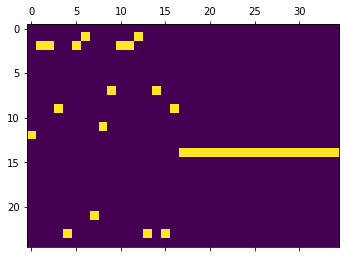

In [18]:
# One hot encoded train and validation data
X_train, Y_train = one_hot_encoding(x_train.values)
X_val, Y_val = one_hot_encoding(x_val.values)

print(x_train.iloc[0])
plt.matshow(X_train[0].T)

In [19]:
# print the first smile string sequence with start and end tokens
"".join([int_to_char[idx] for idx in np.argmax(X_train[0, :, :], axis = 1)])

'!CC1NC(=O)CC(N)N1EEEEEEEEEEEEEEEEEE'

In [20]:
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

In [21]:
# input layer of the encoder
from keras.layers import Dense, Concatenate
encoder_inputs = layers.Input(shape = input_shape)
outputs, state_h, state_c = layers.LSTM(lstm_dim, return_state = True, unroll = False)(encoder_inputs)
concat_states = Concatenate(axis = -1)([state_h, state_c])
latent_outputs = Dense(latent_dim, activation = "relu")(concat_states)

In [22]:
# decode the cell and hidden states of the encoder
h_decoded =  layers.Dense(lstm_dim, activation = "relu")(latent_outputs)
c_decoded =  layers.Dense(lstm_dim, activation = "relu")(latent_outputs)

decoded_states = [h_decoded, c_decoded]
decoder_inputs = layers.Input(shape = input_shape)

decoder_lstm = layers.LSTM(lstm_dim, return_sequences = True, unroll = False)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state = decoded_states)
decoder_outputs = layers.Dense(output_dim, activation = 'softmax')(decoder_outputs)

# define the model
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 35, 25)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 64),         23040       ['input_1[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 concatenate (Concatenate)      (None, 128)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

In [68]:
# compile and fit the model
opt = tf.keras.optimizers.Adam(learning_rate = 0.001) 
model.compile(optimizer = opt, loss = 'categorical_crossentropy')
model.fit([X_train, X_train], Y_train, epochs = 10, batch_size = 516, shuffle = True, validation_data = ([X_val, X_val], Y_val))

Epoch 1/10
663/663 [==============================] - 11s 11ms/step - loss: 0.0126 - val_loss: 0.0097
Epoch 2/10
663/663 [==============================] - 7s 10ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 3/10
663/663 [==============================] - 7s 10ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 4/10
663/663 [==============================] - 7s 10ms/step - loss: 0.0136 - val_loss: 0.0257
Epoch 5/10
663/663 [==============================] - 7s 10ms/step - loss: 0.0098 - val_loss: 0.0092
Epoch 6/10
663/663 [==============================] - 7s 10ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 7/10
663/663 [==============================] - 7s 10ms/step - loss: 0.0146 - val_loss: 0.0106
Epoch 8/10
663/663 [==============================] - 7s 10ms/step - loss: 0.0084 - val_loss: 0.0088
Epoch 9/10
663/663 [==============================] - 7s 10ms/step - loss: 0.0088 - val_loss: 0.0106
Epoch 10/10
663/663 [==============================] - 7s 10ms/step - loss: 0.0212 - val_l

In [69]:
for i in range(100):
  idxs_pred = np.argmax(model.predict([X_val[i:i + 1], X_val[i:i + 1]]), axis = 2)
  pred_smile = "".join([int_to_char[m] for m in idxs_pred[0]])[:-1]

In [70]:
from keras.layers import Dense, Concatenate
neck = Dense(latent_dim, activation="relu")
states = Concatenate(axis=-1)([state_h, state_c])
neck_outputs = neck(states)
smiles_to_latent_space = tf.keras.Model(encoder_inputs, neck_outputs)

smiles_to_latent_space.save("smile_latent.h5") 

In [71]:
# convert validation data into latent space
val_latent = smiles_to_latent_space.predict(X_val)

In [72]:
latent_input = layers.Input(shape = (latent_dim,))

# reuse earlier dense layers
state_h_decoded =  model.get_layer('dense_1')(latent_input)
state_c_decoded =  model.get_layer('dense_2')(latent_input)

latent_to_states_model = tf.keras.Model(latent_input, [state_h_decoded, state_c_decoded])
latent_to_states_model.save("latent_state.h5")

In [73]:
# Model for random sampling
sample_decoder_inputs = layers.Input(batch_shape = (1, 1, input_shape[1]))
lstm_out = layers.LSTM(lstm_dim, return_sequences = True, unroll = False, stateful = True)(sample_decoder_inputs)
dense_out = layers.Dense(output_dim, activation = 'softmax')(lstm_out)

sample_model = tf.keras.Model(sample_decoder_inputs, dense_out)

In [74]:
# Model for random sampling
inf_decoder_inputs = layers.Input(batch_shape = (1, 1, input_shape[1]))
inf_decoder_lstm = layers.LSTM(lstm_dim, return_sequences = True, unroll = False, stateful = True)

inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = layers.Dense(output_dim, activation = 'softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)

sample_model = tf.keras.Model(inf_decoder_inputs, inf_decoder_outputs)

In [75]:
# Transfer learned weights
for i in range(1, 3):
  sample_model.layers[i].set_weights(model.layers[i + 6].get_weights())
sample_model.save("sample_model.h5")

sample_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(1, 1, 25)]              0         
                                                                 
 lstm_7 (LSTM)               (1, 1, 64)                23040     
                                                                 
 dense_12 (Dense)            (1, 1, 25)                1625      
                                                                 
Total params: 24,665
Trainable params: 24,665
Non-trainable params: 0
_________________________________________________________________


In [76]:
# From latent space to SMILES

def latent_to_smiles(latent):
  states = latent_to_states_model.predict(latent)
  sample_model.layers[1].reset_states(states = [states[0], states[1]])
  start_idx = char_to_int["!"]
  sample_vec = np.zeros((1, 1, 25))
  sample_vec[0, 0, start_idx] = 1
  smiles = ""
  for i in range(28):
    out = sample_model.predict(sample_vec)
    sample_idx = np.argmax(out)
    sample_char = int_to_char[sample_idx]
    if sample_char != "E":
      smiles = smiles + int_to_char[sample_idx]
      sample_vec = np.zeros((1, 1, 25))
      sample_vec[0, 0, sample_idx] = 1
    else:
      break
  return smiles

In [77]:
# Generating a list of new SMILES
smiles = []
for i in range(5000):
  smiles.append(latent_to_smiles(val_latent[i:i+1]))
print(f'List of New SMILES generated: {smiles}')

['NCP18F', 'NC1P', 'NC1PO', 'NC1S', 'NC1S', 'NC1OC1', 'NC1CO1', 'NC1S', 'NC1BO', 'NC1CS1', 'CNPP', 'CN1SB1', 'NC1OF', 'NC1S', 'C1NS1C', 'NC18F', 'NC18F', 'NC1OC1', 'CNP1', 'C1NS1C', 'NC1P', 'NC1P', 'CNP=O', 'NC1CO1', 'NC1CO1', 'NC1OS1', 'CN1PCO', 'NC1OC1', 'NC1CO1', 'NC1OC1', 'NC1BO', 'CN1PO', 'NC1CO1', 'NC1CO1', 'NC1CO1', 'NCP', 'NC1OC1', 'NC18F', 'C1NS1', 'NC1S1', 'NC18F', 'NC1CO1', 'C1OC1O', 'NC1SO1', 'NC1OC1', 'CN1CO1', 'NC1S', 'NC1CO1', 'NC1PO', 'C1OCS1', 'NC1P', 'NC1P', 'CNP1CO/O', 'NC1SB1', 'NC1CO1', 'NC18F', 'CN1CO1', 'NC1CO1', 'CNP', 'NC1P', 'C1OC1S', 'NC1OC1', 'NC1PSI3', 'NC1CO1', 'NC1BO', 'NC1CO1', 'C1NS1=O', 'NC1SC1', 'NC1SC1', 'NC1CO', 'NC1OF1', 'NC1OC1', 'NC1S', 'NC1CO1', 'CNPBO', 'NC1CO1', 'NC1PO', 'NC1PC=O', 'NC1O', 'CNP=O', 'NC1O', 'NC1CS1', 'C1NS1C', 'CNP=O', 'CNPP=O', 'NC18F', 'NC1BO1', 'NC18F', 'NC1CO1', 'NC1CO1', 'NC1P', 'CN1S', 'NC1CO1', 'NC1POC', 'NC1SS2', 'NC18F', 'NC1OC1', 'NC1P=O', 'NC1SB1', 'NC1O', 'NC1P', 'NC1S', 'NC1CO1', 'N1CS1', 'NC1S', 'NC1BO', 'NC1CO1',

In [80]:
# Validating the list of SMILES generated

# new_drug_list = []
for i in smiles:
  var = Chem.MolFromSmiles(i,sanitize=True)
  if var != None:
    new_drug_list.append(i)
new_drug_list = list(set(new_drug_list))
print(new_drug_list)

#Printing the list of  valid SMILES generated
print(f'Valid list of SMILES: {len(new_drug_list)}')


['NC=S', 'NC1SN1', 'CNPB', 'NC1BON1', 'C1NS1=O', 'NB1BCO1', 'NC1BOBO1', 'NC1=SSI1', 'NBPB(=O)', 'NCP=B', 'NC1OBN1', 'NC1=SC1', 'NCP(=O)O', 'NBP(=O)O', 'CNP1CO1', 'NC1OB1', 'NBP', 'NCP(=O)', 'NC1BOO1', 'CN1SB1', 'NCP=O', 'C1NS1(N)', 'N1CS1', 'CN1BO1', 'NC1BOS1', 'C1OC1', 'CNPP', 'NP=C(N)O', 'NC1=SS1', 'NB1OBC1', 'C1OCP1', 'C1OC1F', 'NP(C)=O', 'NB1BOC1', 'NC1OS1', 'CNPP=O', 'NBPB=B', 'NCP=S', 'NC1SO1', 'NCPBN', 'CNP=S', 'NC1CS1', 'C1OCS1', 'NP', 'CN1CO1', 'C1NS1', 'CNPB=O', 'NCP', 'NC1BOB1', 'NC1B(O)O1', 'NC1BO1', 'CNP=O', 'N1CO1', 'CNP1BO1', 'CNP', 'CN1PSI1', 'NC1CO1', 'C1OC1S', 'C1OC1O', 'NC1SB1', 'C1NS1C', 'CNPP=N', 'NC1SC1', 'NC=S=S', 'NC1SI1', 'NC1OC1', 'CNPBO', 'NBOBC']
Valid list of SMILES: 68


In [82]:
# Checking if the validated SMILES are present in the ZINC database
zincid_count=0
for drug in new_drug_list:
  zinc_id = smilite.get_zincid_from_smile(drug)
  if len(zinc_id)!=0:
    zincid_count+=1
    # print(zinc_id)

# Count of ZINC Ids matched with ZINC database
print(f'Count of ZINC Ids matched: {zincid_count}')
print(f'Unique SMILES generated: {len(new_drug_list)-zincid_count}')


Count of ZINC Ids matched: 21
Unique SMILES generated: 47
